# Stroke Patient Dataset Analysis and Predictive Modeling with Logistic Regression

*I completed the project independently with suggestions from my mentor Mengting Zhang. The dataset used in this project is a public dataset available on the Kaggle website.*

#### Project Summary

The goal of this project is to analyze the important factors that contribute to stroke events in patients. We will first clean and explore the stroke patient dataset, and then we will build a logistic regression model to predict stroke events in patients.

**NOTE: imbalanced-learn package must be installed first in order to run this analysis script.**<br>
**Please run the following command from Terminal**

pip install imbalanced-learn

#### Setup

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report

#set plot sytle
sns.set_style("darkgrid")

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Part 1: Import Data and Preprocess Data

#### (I) Import data and Initial Inspection

In [3]:
stroke_dataset = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [4]:
stroke_dataset.head() #look at the first 5 rows of the dataset

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
stroke_dataset.info() #provide an overview of data type for each variable and counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Based on the summary above, it is worth noting that there are missing values in the 'bmi' column. Let's first take a look at the 'bmi' distribution. And we will plot the non-null data in the 'bmi' column.

#### (II) Handle Missing Values

In [5]:
stroke_dataset['bmi'].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

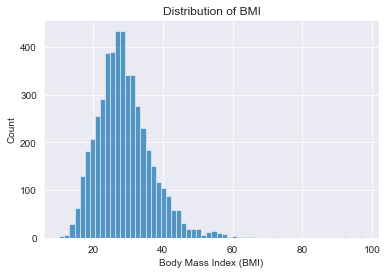

In [6]:
fig1 = sns.histplot(stroke_dataset['bmi'],bins=60)
fig1.set(xlabel = 'Body Mass Index (BMI)')
fig1.set(title = 'Distribution of BMI')
plt.show()

Based on the distribution plot above, we can see that the distribution of BMI is not perfectly symmetrical with some outliers > 80. Also, we don't have much information in this dataset to predict BMI from other columns easily. Therefore, we will apply imputation with median value to fill the missing values in the 'bmi' column.

In [7]:
#apply median imputation
stroke_dataset['bmi'] = stroke_dataset['bmi'].fillna(stroke_dataset['bmi'].median()) 

Now we can take a look at the summary of the 'bmi' column again to check whether we still have any missing value.

In [8]:
stroke_dataset['bmi'].describe()

count    5110.000000
mean       28.862035
std         7.699562
min        10.300000
25%        23.800000
50%        28.100000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

We can see that now the count 5110 matches with the count value of other variables. Thus all the missing values have been filled. We can also notice that after median impuation, the mean hasn't changed much compared to the original mean. We can plot the distribution of BMI again to double check.

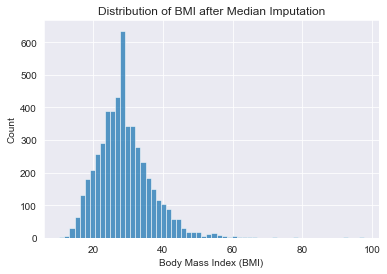

In [9]:
fig2 = sns.histplot(stroke_dataset['bmi'],bins=60)
fig2.set(xlabel = 'Body Mass Index (BMI)')
fig2.set(title = 'Distribution of BMI after Median Imputation')
plt.show()

We can observe from the plot above that there is an increased count for the median BMI as expected. The distribution of BMI is very similar to the original distribution of BMI, which is desirable after median imputation. 

#### (III) Recode Categorical Predictor Variables

There are five categorical predictor variables: gender, ever_married, work_type, Residence_type, and smoking_status. In the original dataframe, they are formatted as 'object' in data type. We will create dummy variables for these five categorical predictors.

##### (1) Gender

In [43]:
gender_dummies = pd.get_dummies(stroke_dataset['gender'])

In [44]:
gender_dummies_renamed = gender_dummies.rename(columns={'Other': 'Nonbinary'})

In [45]:
gender_dummies_renamed.head()

,Female,Male,Nonbinary
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [46]:
stroke_dataset_extended1 = stroke_dataset.join(gender_dummies)

In [47]:
stroke_dataset_extended1.shape

(5110, 15)

##### (2) Ever married

In [48]:
married_dummies = pd.get_dummies(stroke_dataset['ever_married'])

In [49]:
married_dummies_renamed = married_dummies.rename(columns={'No': 'Married_No','Yes':'Married_Yes'})

In [50]:
married_dummies_renamed.head()

,Married_No,Married_Yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [55]:
stroke_dataset_extended2 = stroke_dataset_extended1.join(married_dummies_renamed)

In [56]:
stroke_dataset_extended2.shape

(5110, 17)

##### (3)Work type

In [53]:
worktype_dummies = pd.get_dummies(stroke_dataset['work_type'])

In [54]:
worktype_dummies.head()

,Govt_job,Never_worked,Private,Self-employed,children
0,0,0,1,0,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,1,0


In [57]:
stroke_dataset_extended3 = stroke_dataset_extended2.join(worktype_dummies)

In [58]:
stroke_dataset_extended3.shape

(5110, 22)

##### (4) Residence type

In [65]:
residence_dummies = pd.get_dummies(stroke_dataset['Residence_type'])

In [66]:
residence_dummies.head()

,Rural,Urban
0,0,1
1,1,0
2,1,0
3,0,1
4,1,0


In [67]:
stroke_dataset_extended4 = stroke_dataset_extended3.join(residence_dummies)

In [68]:
stroke_dataset_extended4.shape

(5110, 24)

##### (5) Smoking status

In [69]:
smoking_dummies = pd.get_dummies(stroke_dataset['smoking_status'])

In [72]:
smoking_dummies_renamed = smoking_dummies.rename(columns={'Unknown': 'Unknown_smoke_hist'})

In [73]:
smoking_dummies_renamed.head()

,Unknown_smoke_hist,formerly smoked,never smoked,smokes
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,0,1
4,0,0,1,0


In [74]:
stroke_dataset_extended5 = stroke_dataset_extended4.join(smoking_dummies_renamed)

In [75]:
stroke_dataset_extended5.shape

(5110, 28)

Now we can check the data type for each variable again after the recoding step.

In [76]:
stroke_dataset_extended5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5110 non-null   int64  
 1   gender              5110 non-null   object 
 2   age                 5110 non-null   float64
 3   hypertension        5110 non-null   int64  
 4   heart_disease       5110 non-null   int64  
 5   ever_married        5110 non-null   object 
 6   work_type           5110 non-null   object 
 7   Residence_type      5110 non-null   object 
 8   avg_glucose_level   5110 non-null   float64
 9   bmi                 5110 non-null   float64
 10  smoking_status      5110 non-null   object 
 11  stroke              5110 non-null   int64  
 12  Female              5110 non-null   uint8  
 13  Male                5110 non-null   uint8  
 14  Other               5110 non-null   uint8  
 15  Married_No          5110 non-null   uint8  
 16  Marrie

In [77]:
stroke_dataset_extended5.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,Never_worked,Private,Self-employed,children,Rural,Urban,Unknown_smoke_hist,formerly smoked,never smoked,smokes
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,...,0,1,0,0,0,1,0,1,0,0
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,...,0,0,1,0,1,0,0,0,1,0
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,...,0,1,0,0,1,0,0,0,1,0
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,...,0,1,0,0,0,1,0,0,0,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,...,0,0,1,0,1,0,0,0,1,0


#### (IV) Examine the Response Variable ('stroke')

We will examine the response variable that we are primarily interested in, the 'stroke' column, which indicates whether the patient has a stroke (1) or not have a stroke (0). 

In [78]:
stroke_dataset_extended5['stroke'].value_counts() #count the number of occurrences in each category

0    4861
1     249
Name: stroke, dtype: int64

Here it is important to note that in this dataset, 4861 patients didn't have stroke, and 249 patients had stroke. The dataset is clearly imbalanced, which is not desirable for training a machine learning model. We need to undertake some measure to ensure that the dataset is balanced so that our model can perform better. 

#### (V) Handle Imbalanced Data

There are multiple ways to deal with imbalanced data (e.g., oversample minority class, undersample majority class, etc.). Here we will use the SMOTE (Synthetic Minority Oversampling Technique) strategy in order to generate a balanced dataset.

*Reference:* https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

In [79]:
#split the dataset into predictor variable columns and the response variable column
#also need to drop the unnecessary columns
predictors = stroke_dataset_extended5.drop(columns=['id', 'stroke','gender','ever_married','work_type','Residence_type','smoking_status'])
response = stroke_dataset_extended5['stroke']

In [103]:
print(predictors.shape)

(5110, 21)


In [104]:
#create a balanced dataset with SMOTE
sm = SMOTE(random_state = 99) 
balanced_predictors, balanced_response = sm.fit_resample(predictors, response) 

Now we can check the response variable ('stroke') again.

In [105]:
balanced_response.value_counts() 

0    4861
1    4861
Name: stroke, dtype: int64

After applying SMOTE to upsampling the original dataset, we now have an equal number of patients who had stroke and patients who didn't have stroke. 

### Part 2: Build a Logistic Regression Model

#### (I) Check Multicollinearity among the predictor variables

Multicollinearity (variables are highly correlated to each other) can be a serious issue in model building and impairs the performance of the model. We want to ensure that the predictor variables put into the logistic regression model algorithm are independent and not highly correlated to each other.

In [106]:
#create the correlation matrix for the predictor variables
corr_matrix = balanced_predictors.corr()

[Text(0.5, 1.0, 'Heatmap of Pairwise Correlation between Predictor Variables')]

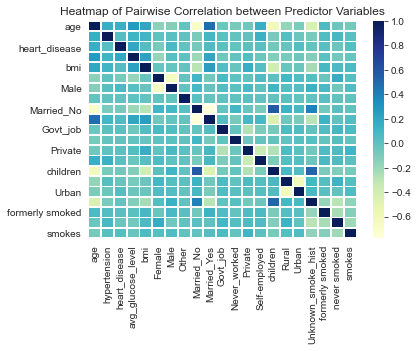

In [107]:
#create heatmap of the pairwise correlation
fig3 = sns.heatmap(corr_matrix,cmap="YlGnBu",annot=False,linewidths=.8)
fig3.set(title="Heatmap of Pairwise Correlation between Predictor Variables")

Based on the pairwise correlation heatmap shown above, we can observe that there is no significant correlation (pairwise correlation >= 0.9) between any of the two predictor variables. Therefore, we don't need to remove any predictor variable due to multicollinearity. Now we will proceed to automated feature selection and build the logistic regression model.

#### (II) Split Dataset into Model Training & Final Testing Sets

The model training set will include the training and testing sets used in subsequent model fitting step. The final testing set will be a fresh test set used for evaluating model performance at the end.

In [108]:
model_train_X, final_test_X, model_train_Y, final_test_Y = train_test_split(balanced_predictors, balanced_response, test_size=0.2)
print(model_train_X.shape, final_test_X.shape, model_train_Y.shape, final_test_Y.shape)

(7777, 21) (1945, 21) (7777,) (1945,)


#### (III) Automated Feature Selection

We will use **recursive feature elimination with cross validation (RFECV)** to find the best set of features for our logistic regression model. This algorithm will tell us the optimal number of features  to input into our model and also what these features are after cross validation. Here we choose 10-fold cross validation.

*References*: 
1. https://www.kaggle.com/residentmario/automated-feature-selection-with-sklearn
2. https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
3. https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-02-11262b7f7a5c

In [109]:
stroke_regression_model = LogisticRegression(max_iter=500)
#we will apply 10-fold cross validation with RFE
stroke_rfecv = RFECV(stroke_regression_model, step=1, cv=10, scoring='accuracy')
stroke_rfecv.fit(model_train_X, model_train_Y)

RFECV(cv=10, estimator=LogisticRegression(max_iter=500), scoring='accuracy')

[Text(0, 0.5, 'CV Score (Accuracy)')]

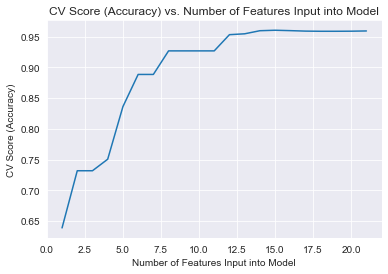

In [110]:
#visually display the optimal number of features to input into model
fig4 = sns.lineplot(range(1,len(stroke_rfecv.grid_scores_)+1), stroke_rfecv.grid_scores_)
fig4.set(title='CV Score (Accuracy) vs. Number of Features Input into Model')
fig4.set(xlabel="Number of Features Input into Model")
fig4.set(ylabel="CV Score (Accuracy)")

The plot above shows that the accuracy is the highest when we input >= 15 variables into the model. To avoid overfitting, we will use 15 variables.

In [112]:
#find the list of selected variables to put into the model
screened_variables = list(zip(balanced_predictors.columns.values, stroke_rfecv.support_))
selected_variables = []
for key,value in enumerate(screened_variables):
    if(value[1]) == True:
        selected_variables.append(value[0])
        
print(selected_variables)

['Female', 'Male', 'Married_No', 'Married_Yes', 'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children', 'Rural', 'Urban', 'Unknown_smoke_hist', 'formerly smoked', 'never smoked', 'smokes']


 #### (IV) Logistic Regression Modeling

In [113]:
stroke_fitted_model = stroke_regression_model.fit(model_train_X[selected_variables], model_train_Y)

In [115]:
#Show the regression coefficient associated with each predictor variable
pd.DataFrame({"Predictor Variables":model_train_X[selected_variables].columns.tolist(),"Coefficients":np.round(stroke_fitted_model.coef_[0],3)})

,Predictor Variables,Coefficients
0,Female,-4.432
1,Male,-4.295
2,Married_No,-4.935
3,Married_Yes,-3.457
4,Govt_job,-4.523
5,Never_worked,-2.341
6,Private,-3.897
7,Self-employed,-4.007
8,children,-4.604
9,Rural,-4.741


### Part 3: Make Prediction and Model Evaluation

Now we will use our final test set which hasn't been used in model training yet to evaluate how accurate our logistic regression model is. 

#### (I) Make Predictions

In [118]:
stroke_predictions = stroke_fitted_model.predict(final_test_X[selected_variables])

#### (II) Model Evaluation

##### (1) Accuracy Score

In [119]:
print(np.round(accuracy_score(final_test_Y, stroke_predictions),3))

0.96


Our model yields 96% accuracy in predicting stroke events in patients in the test set.

##### (2) Confusion Matrix

In [120]:
stroke_cm = pd.DataFrame(confusion_matrix(final_test_Y, np.round(stroke_predictions,2)))

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

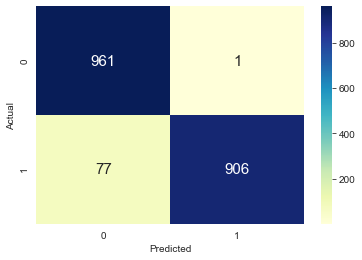

In [121]:
stroke_cm.index.name = 'Actual'
stroke_cm.columns.name = 'Predicted'
sns.heatmap(stroke_cm, cmap="YlGnBu", annot=True,annot_kws={"size": 15},fmt='g')

Based on the confusion matrix shown above, 906 patients who really had stroke are predicted correctly (true positive). 77 patients who really had stroke are predicted wrongly (false negative). 961 patients who really didn't have stroke are predicted correctly (not have stroke, true negative). And lastly, 1 patient who really didn't have stroke are predicted wrongly (have stroke, false positive). 

##### (3) ROC curve

<AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Postitive Rate'>

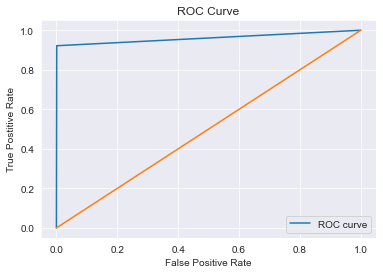

In [122]:
false_positive_rate, true_positive_rate,thresholds = roc_curve(final_test_Y, stroke_predictions)
fig6 = sns.lineplot(false_positive_rate, true_positive_rate, label='ROC curve')
fig6.set(title="ROC Curve")
fig6.set(xlabel="False Positive Rate")
fig6.set(ylabel="True Postitive Rate")
#show the 45 degrees line
x = np.arange(0,1.1,0.1)
y = np.arange(0,1.1,0.1)
sns.lineplot(x,y)

The 45 degrees line represents random guessing. The plot above suggests that our model performs better than random guessing.

In [123]:
np.round(roc_auc_score(final_test_Y, stroke_predictions),3)

0.96

The area under the ROC curve is 0.96, which is greater than 0.5 (random guessing). 

#### Conclusion

In this analysis project, we first cleaned the dataset and used the SMOTE strategy to upsample the imbalanced response variable data ("stroke" events). Next, we recoded the categorical predictor variables into binary values so that they can be input into the regression model. Afterwards, we applied the RFECV algorithm to select the optimal set of features with 10-fold cross validation. The algorithm output 15 features to be used in the model. Finally, after building the logistic regression model, we evaluated the model accuracy by running the model on the test set (20% of the original dataset, not used in model training). Our model yields 96% accuracy in predicting stroke events in patients.